## Structural similarity

In [67]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

In [2]:
#Tanimoto similarity function

def tanimoto(vector1, vector2):
    set_bits = 0
    shared_bits = 0
    for bit1, bit2 in zip(vector1, vector2):
        if bit1 or bit2: 
            set_bits += 1
            if bit1 and bit2:
                shared_bits += 1
    return shared_bits / set_bits


0.0
0.3333333333333333
0.5
0.75
1.0


In [6]:
# Trying Tanimoto function on examples
print(tanimoto([1, 0, 0, 0], [0, 1, 1, 1])) # no similarity
print(tanimoto([0, 0, 1, 0], [0, 0, 1, 0])) # similiar
print(tanimoto([1, 1, 1, 1], [0, 0, 1, 1])) # similiar
print(tanimoto([1, 0, 1, 1], [0, 0, 1, 1])) # similiar
print(tanimoto([1, 1, 0, 0], [1, 1, 0, 0])) # equal

0.0
1.0
0.5
0.6666666666666666
1.0


In [9]:
#Load data
df_can = pd.read_csv('cannabinoid.csv', delimiter=';')

In [10]:
#Clean data
df1 = df_can.dropna(subset=['Smiles'])

In [11]:
#List of molecules instances
ligandm_database = []
for ligand in df1["Smiles"]:
		ligandm_database.append(Chem.MolFromSmiles(ligand))

In [12]:
#Load drugbank data
drugbank = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in drugbank if m]

In [15]:
#MACCSkeys
fp1 = MACCSkeys.GenMACCSKeys(drugs[100])
fp2 = MACCSkeys.GenMACCSKeys(drugs[601])
print(fp1.ToBitString())
print(fp2.ToBitString())

00000000000000000001000000000010000000000000000001000000000000000010000010000000000101100000000011101000010000011000001001110111110010000111000101111000111011110111110
00000000000000000100000000100000000000000000000000100000000000000010000000001000000000000011000010010100110010001001101000000001110010000001000101010010101001011001110


In [16]:
tanimoto(fp1, fp2)

0.3389830508474576

In [18]:
#DataStruts
DataStructs.TanimotoSimilarity(fp1, fp2)

0.3389830508474576

In [26]:
#MACCS keys for ligands
can_ligands_maccs = [MACCSkeys.GenMACCSKeys(m) for m in ligandm_database]
drugs_maccs = [MACCSkeys.GenMACCSKeys(m) for m in drugs]

In [21]:
#Function similarity search
def similarity_search(query_fp, searched_fp_set, cutoff=0.8):
    # we have no index, so we will have to just iterate through the entire searched set
    hits = []
    for i, fp in enumerate(searched_fp_set):
        similarity = DataStructs.TanimotoSimilarity(query_fp, fp)
        if similarity >= cutoff: # similar enough for consideration
            hits.append((i, similarity))
    return sorted(hits, key=lambda x: x[1], reverse=True) # stronger hits first

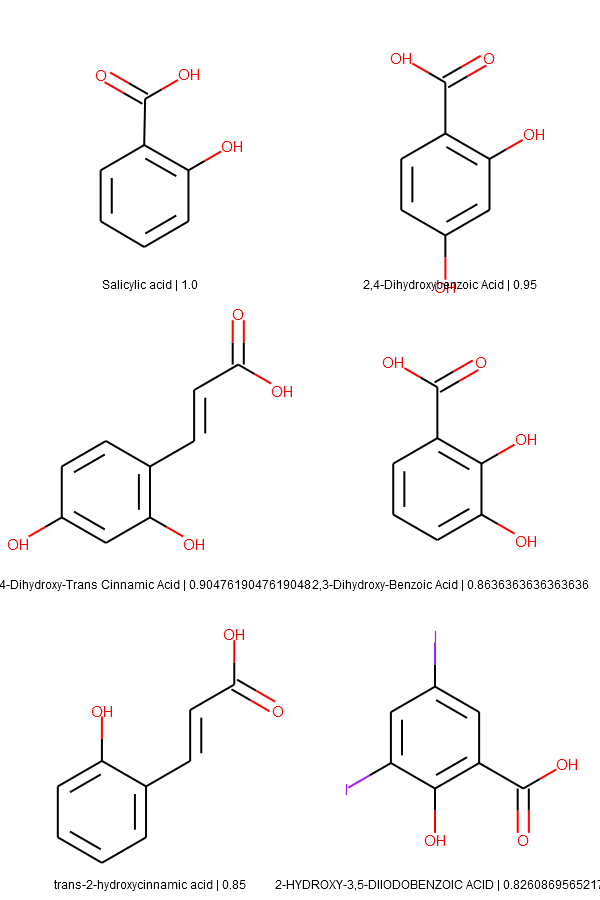

In [27]:
# Search salicylic acid in drugs
salicylic_acid_pattern = Chem.MolFromSmiles('c1ccc(c(c1)C(=O)O)O')
salicylic_acid_pattern_fp = MACCSkeys.GenMACCSKeys(salicylic_acid_pattern)
hits = similarity_search(salicylic_acid_pattern_fp, drugs_maccs)
Draw.MolsToGridImage([drugs[hit[0]] for hit in hits],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=["{} | {}".format(drugs[hit[0]].GetProp('GENERIC_NAME'), hit[1]) for hit in hits])

In [31]:
#Look for molecules in our dataset against drugbank
hits = similarity_search(can_ligands_maccs[1], drugs_maccs)
hits

[(6565, 0.8656716417910447),
 (1600, 0.8309859154929577),
 (6007, 0.8055555555555556)]

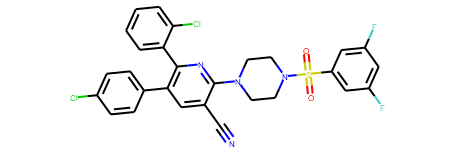

In [32]:
ligandm_database[1]

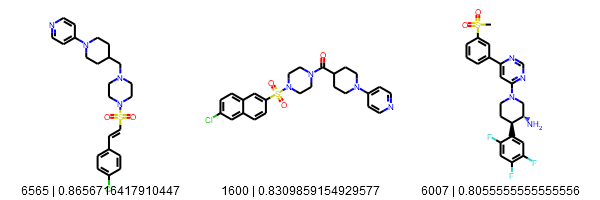

In [33]:
#Hits in Drugbank 
Draw.MolsToGridImage([drugs[hit[0]] for hit in hits], legends=["{} | {}".format(hit[0], hit[1]) for hit in hits])

In [34]:
#ECFP 
can_ligands_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
                     for m in ligandm_database]
drugs_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
              for m in drugs]

In [43]:
#Similarirty bwtween my ECFP of my dataset and ECFP of my drugs
hits = similarity_search(can_ligands_ecfp[1], drugs_ecfp)
hits

[]

In [44]:
#TanimotoSimilarity
DataStructs.TanimotoSimilarity(can_ligands_ecfp[1], drugs_ecfp[6565])

0.23529411764705882

In [46]:
#TanimotoSimilarity
DataStructs.TanimotoSimilarity(can_ligands_ecfp[0], drugs_ecfp[5430])

0.08888888888888889

In [47]:
#TanimotoSimilarity
DataStructs.TanimotoSimilarity(can_ligands_ecfp[0], drugs_ecfp[5430])

0.08888888888888889

In [48]:
#Ligand ECFP vs drugbank
can_ligands_queries = [(i, similarity_search(ligand_ecfp, drugs_ecfp))
                     for i, ligand_ecfp in enumerate(can_ligands_ecfp)]
can_ligands_queries

[(0, []),
 (1, []),
 (2, []),
 (3, []),
 (4, []),
 (5, []),
 (6, []),
 (7, []),
 (8, []),
 (9, []),
 (10, [(307, 1.0)]),
 (11, [(660, 1.0)]),
 (12, [(941, 1.0)]),
 (13, []),
 (14, []),
 (15, []),
 (16, []),
 (17, [(756, 1.0)]),
 (18, []),
 (19, []),
 (20, []),
 (21, []),
 (22, []),
 (23, []),
 (24, []),
 (25, []),
 (26, []),
 (27, []),
 (28, []),
 (29, [(449, 1.0)]),
 (30, [(427, 1.0)]),
 (31, []),
 (32, [(605, 1.0)]),
 (33, []),
 (34, [(678, 1.0)]),
 (35, []),
 (36, [(667, 1.0)]),
 (37, [(1019, 1.0)]),
 (38, [(702, 1.0)]),
 (39, []),
 (40, []),
 (41, []),
 (42, []),
 (43, []),
 (44, []),
 (45, []),
 (46, []),
 (47, []),
 (48, []),
 (49, []),
 (50, []),
 (51, []),
 (52, []),
 (53, []),
 (54, [(153, 1.0)]),
 (55, []),
 (56, []),
 (57, []),
 (58, []),
 (59, [(573, 1.0)]),
 (60, []),
 (61, []),
 (62, []),
 (63, []),
 (64, []),
 (65, []),
 (66, [(1080, 1.0)]),
 (67, [(628, 1.0)]),
 (68, [(1027, 1.0)]),
 (69, []),
 (70, []),
 (71, []),
 (72, []),
 (73, []),
 (74, []),
 (75, []),
 (76, []),


In [49]:
# Matched ligands in DrugBank
can_ligand_hits = [hit for hit in can_ligands_queries if hit[1]]
can_ligand_hits

[(10, [(307, 1.0)]),
 (11, [(660, 1.0)]),
 (12, [(941, 1.0)]),
 (17, [(756, 1.0)]),
 (29, [(449, 1.0)]),
 (30, [(427, 1.0)]),
 (32, [(605, 1.0)]),
 (34, [(678, 1.0)]),
 (36, [(667, 1.0)]),
 (37, [(1019, 1.0)]),
 (38, [(702, 1.0)]),
 (54, [(153, 1.0)]),
 (59, [(573, 1.0)]),
 (66, [(1080, 1.0)]),
 (67, [(628, 1.0)]),
 (68, [(1027, 1.0)]),
 (109, [(354, 1.0)]),
 (110, [(515, 1.0), (7097, 0.8636363636363636)]),
 (111, [(328, 1.0)]),
 (114, [(252, 1.0)]),
 (116, [(115, 1.0)]),
 (118, [(214, 1.0)]),
 (124, [(742, 1.0)]),
 (126, [(722, 1.0)]),
 (129, [(792, 1.0)]),
 (132, [(712, 1.0)]),
 (134, [(691, 1.0), (5333, 1.0)]),
 (135, [(1100, 1.0)]),
 (140, [(2383, 1.0)]),
 (141, [(964, 1.0)]),
 (148, [(676, 1.0)]),
 (152, [(687, 1.0)]),
 (153, [(560, 1.0), (3969, 0.8974358974358975)]),
 (159, [(1116, 1.0)]),
 (161, [(224, 1.0), (4861, 1.0)]),
 (162, [(1043, 1.0)]),
 (163, [(1055, 1.0)]),
 (164, [(648, 0.8620689655172413)]),
 (166, [(1209, 1.0)]),
 (193, [(4543, 1.0)]),
 (194, [(4543, 1.0)]),
 (195,

In [50]:
len(can_ligands_queries), len(can_ligand_hits)

(2998, 672)

There are 672 ligands that are structurally similar to ligands in Drugbank

In [51]:
can_ligand_hits[1]

(11, [(660, 1.0)])

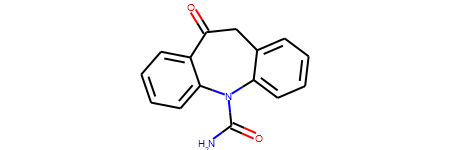

In [54]:
# My query structure
ligandm_database[can_ligand_hits[1][0]]

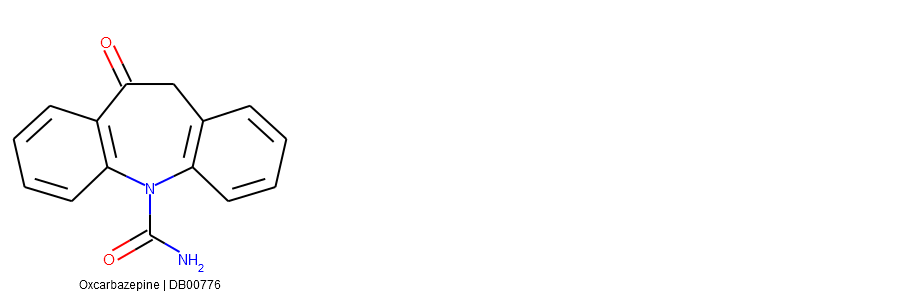

In [57]:
# DrugBank that hits to that in my dataset
hit_mols = [drugs[index] for index, similarity in can_ligand_hits[1][1]]
Draw.MolsToGridImage(hit_mols, molsPerRow=3, subImgSize=(300,300),
                     legends=["{} | {}".format(m.GetProp('GENERIC_NAME'), m.GetProp('DRUGBANK_ID'))
                              for m in hit_mols])

In [59]:
# DrugBank hits from all query ligands
drugs_hitcounts = {}
for ligand, hits in can_ligand_hits:
    for hit, similarity in hits:
        drugs_hitcounts[hit] = drugs_hitcounts.get(hit, 0) + 1
drugs_hitcounts

{307: 1,
 660: 1,
 941: 1,
 756: 1,
 449: 1,
 427: 1,
 605: 1,
 678: 1,
 667: 1,
 1019: 1,
 702: 1,
 153: 1,
 573: 1,
 1080: 1,
 628: 1,
 1027: 1,
 354: 1,
 515: 1,
 7097: 1,
 328: 1,
 252: 1,
 115: 1,
 214: 1,
 742: 1,
 722: 1,
 792: 1,
 712: 1,
 691: 1,
 5333: 1,
 1100: 1,
 2383: 1,
 964: 1,
 676: 1,
 687: 1,
 560: 1,
 3969: 1,
 1116: 1,
 224: 1,
 4861: 1,
 1043: 1,
 1055: 1,
 648: 1,
 1209: 1,
 4543: 38,
 1220: 1,
 938: 1,
 4641: 1,
 1092: 1,
 1098: 1,
 5342: 1,
 218: 2,
 1221: 1,
 945: 1,
 624: 1,
 1247: 1,
 28: 1,
 4454: 1,
 414: 1,
 1003: 1,
 5562: 1,
 4308: 1,
 181: 1,
 332: 3,
 876: 3,
 579: 4,
 1176: 1,
 465: 1,
 87: 1,
 892: 1,
 976: 1,
 1429: 1,
 4310: 2,
 453: 2,
 375: 1,
 4644: 1,
 4848: 1,
 4777: 1,
 315: 1,
 385: 1,
 1381: 1,
 4296: 1,
 5829: 1,
 1097: 1,
 164: 1,
 1117: 1,
 362: 1,
 231: 2,
 830: 2,
 262: 1,
 279: 2,
 1084: 1,
 7014: 1,
 1239: 1,
 894: 1,
 1018: 1,
 365: 1,
 339: 1,
 873: 1,
 1233: 1,
 3196: 1,
 356: 1,
 84: 1,
 152: 1,
 664: 1,
 564: 1,
 526: 1,
 344: 

In [60]:
#Sorted
ordered_drugs_hitcounts = sorted(drugs_hitcounts.keys(), key=lambda x: drugs_hitcounts[x], reverse=True)
ordered_drugs_hitcounts

[4543,
 579,
 90,
 332,
 876,
 919,
 456,
 2939,
 455,
 928,
 6927,
 330,
 1109,
 505,
 218,
 4310,
 453,
 231,
 830,
 279,
 302,
 937,
 1411,
 1066,
 1087,
 242,
 1128,
 187,
 881,
 186,
 408,
 639,
 861,
 1518,
 566,
 508,
 714,
 1076,
 840,
 476,
 925,
 1663,
 3547,
 1053,
 426,
 98,
 1077,
 923,
 1212,
 278,
 991,
 289,
 357,
 199,
 210,
 732,
 320,
 888,
 6928,
 3497,
 1013,
 1041,
 2678,
 307,
 660,
 941,
 756,
 449,
 427,
 605,
 678,
 667,
 1019,
 702,
 153,
 573,
 1080,
 628,
 1027,
 354,
 515,
 7097,
 328,
 252,
 115,
 214,
 742,
 722,
 792,
 712,
 691,
 5333,
 1100,
 2383,
 964,
 676,
 687,
 560,
 3969,
 1116,
 224,
 4861,
 1043,
 1055,
 648,
 1209,
 1220,
 938,
 4641,
 1092,
 1098,
 5342,
 1221,
 945,
 624,
 1247,
 28,
 4454,
 414,
 1003,
 5562,
 4308,
 181,
 1176,
 465,
 87,
 892,
 976,
 1429,
 375,
 4644,
 4848,
 4777,
 315,
 385,
 1381,
 4296,
 5829,
 1097,
 164,
 1117,
 362,
 262,
 1084,
 7014,
 1239,
 894,
 1018,
 365,
 339,
 873,
 1233,
 3196,
 356,
 84,
 152,
 664,
 5

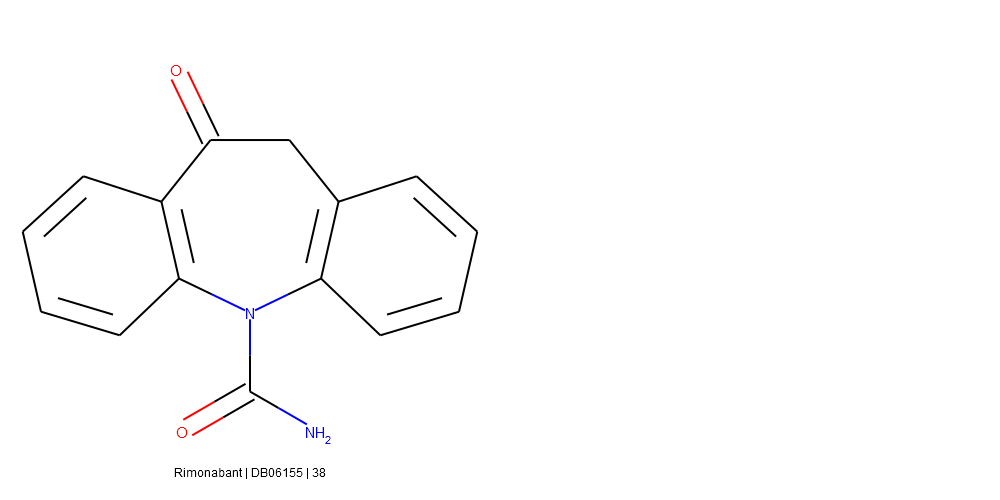

In [61]:
it_mols = [drugs[i] for i in ordered_drugs_hitcounts]
Draw.MolsToGridImage(hit_mols, molsPerRow=2, subImgSize=(500,500),
                     legends=["{} | {} | {}".format(drugs[i].GetProp('GENERIC_NAME')[:30],
                                                    drugs[i].GetProp('DRUGBANK_ID'),
                                                    drugs_hitcounts[i])
                              for i in ordered_drugs_hitcounts])

The most frequently hit substances in the DrugBank database is Rimonabant. It is an anorectic anti-obesity drug produced and marketed by Sanofi-Aventis. It is an inverse agonist for the cannabinoid receptor CB1. Its main avenue of effect is reduction in appetite. Rimonabant is the first selective CB1 receptor blocker to be approved for use anywhere in the world. 
[source: https://pubchem.ncbi.nlm.nih.gov]

# Diversity

In [64]:
def distance_function(index1, index2, *args, fingerprints=can_ligands_ecfp,
                      metric=DataStructs.TanimotoSimilarity):
    return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1],
                                                 fingerprints[index2],
                                                 metric=metric)

In [68]:
picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(ligandm_database), 45))
picked

[2794,
 1281,
 2708,
 2425,
 759,
 1719,
 2360,
 2053,
 1512,
 860,
 206,
 1646,
 59,
 1151,
 613,
 276,
 1681,
 2367,
 1787,
 358,
 2305,
 505,
 1274,
 1596,
 510,
 580,
 595,
 2156,
 1052,
 1765,
 2076,
 519,
 1562,
 2344,
 54,
 1182,
 2101,
 2408,
 1184,
 797,
 959,
 2148,
 953,
 961,
 2124]

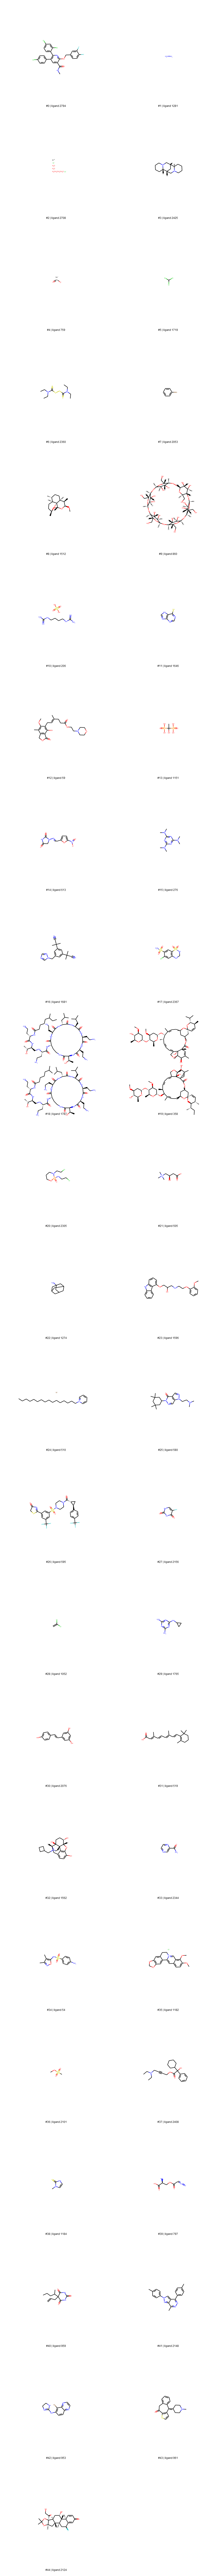

In [70]:
#Chemically diverse molecules
Draw.MolsToGridImage([ligandm_database[i] for i in picked], molsPerRow=2, subImgSize=(500,500),
                     legends=["#{} | ligand {}".format(i, hit) for i, hit in enumerate(picked)])

So, here we have pretty diverse molecules in my dataset.